## Combinbing Images

Create pseudo foveated mongrels by combining mongrels at different eccentricities

In [21]:
# read in 3 mongrels
import cv2
import matplotlib.pyplot as plt
import numpy as np

base_directory = './60_olap_sweep'
image_number = 19
eccentricities = [0,50,100,150,200,250,300,450]

image_name = str(image_number).zfill(12)

./coco_test/000000000019.jpg


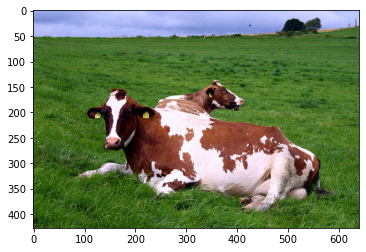

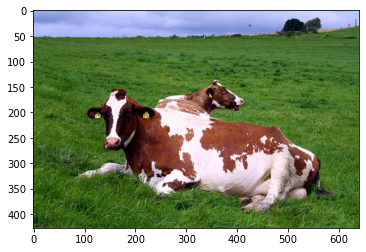

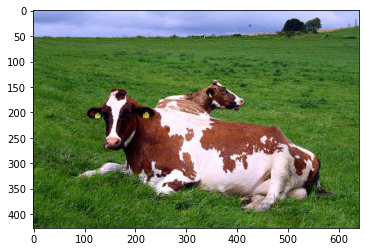

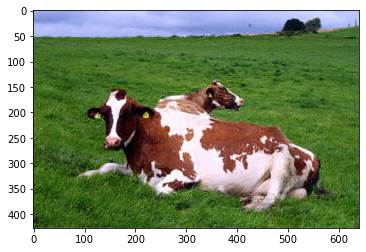

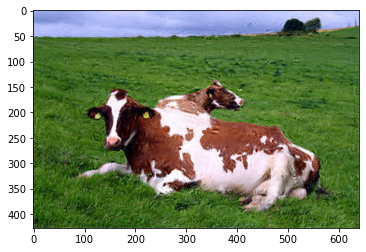

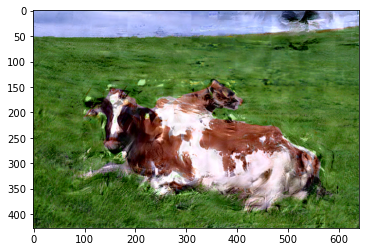

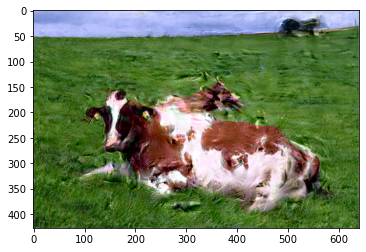

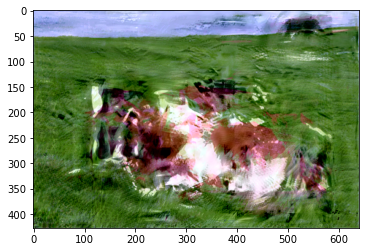

In [22]:
def readin_mongrels(eccentricities_list, image_name, base_directory, showims=False):
    imgs = []
    
    #original image
    original_fname = f'./coco_test/{image_name}.jpg'
    print(original_fname)
    ori_img = cv2.imread(original_fname)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    imgs.append(ori_img)
    if(showims):
        plt.imshow(ori_img)
        plt.show()
    
    #eccentricities
    for e in eccentricities_list[1:]:
        mongrel_fname = f'{base_directory}/{image_name}_X{e}_YNaN_2022-08-12_uniform_60olap_{e}/mongrelized_{image_name}_uniform_60olap_{e}.png'
        mong = cv2.imread(mongrel_fname)
        mong = cv2.cvtColor(mong, cv2.COLOR_BGR2RGB)
        imgs.append(mong)
        #print(mong)
        
        if(showims):
            plt.imshow(mong)
            plt.show()
    return(imgs)

mongs = readin_mongrels(eccentricities, image_name, base_directory, showims=True)

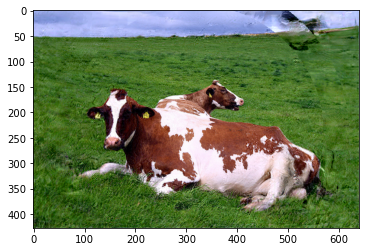

In [23]:
def create_psuedo_foveated_img(mongrel_vector):
    
    foveation_location = (320,240)
    fovea_size = 16

    img_shape = np.shape(mongrel_vector[0])

    # Calculate the indices from the image
    y, x = np.indices(img_shape[:-1])
    num_bins = np.min(img_shape[:-1])

    normalized = ((x-foveation_location[0]),(y-foveation_location[1]))
    r = np.hypot(normalized[0], normalized[1])

    pseudo_foveated = np.zeros_like(mongrel_vector[0])

    for i, ecc in enumerate(eccentricities):
        if(i==0):
            min_ecc = 0
            max_ecc = fovea_size
        # elif(i==1):
        #     min_ecc = fovea_size
        #     max_ecc = eccentricities[i]
        else:
            min_ecc = eccentricities[i-1]
            max_ecc = eccentricities[i]

        #print(i,ecc, min_ecc, max_ecc)

        #don't calculate corners
        ecc_mask = np.where((r>=min_ecc) & (r<max_ecc), True, False)

#         debugging
#         plt.imshow(r)
#         plt.colorbar()
#         plt.show()

#         plt.imshow(1*ecc_mask)
#         plt.colorbar()
#         plt.show()

        pseudo_foveated[ecc_mask,:] = mongrel_vector[i-1][ecc_mask,:]
    
    return(pseudo_foveated)

psuedo_foveated_mongrel = create_psuedo_foveated_img(mongs)
plt.imshow(psuedo_foveated_mongrel)

./coco_test/000000000019.jpg


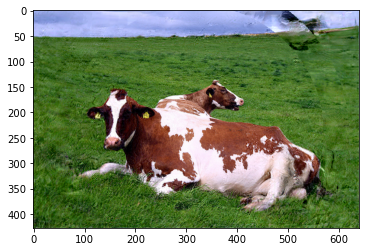

./coco_test/000000000069.jpg


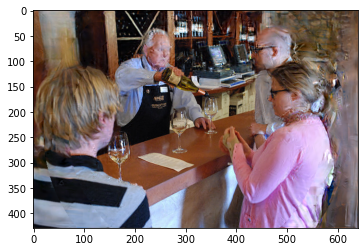

./coco_test/000000000979.jpg


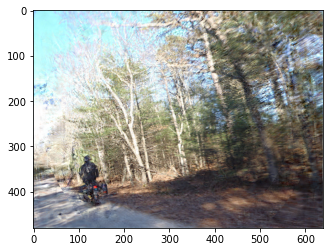

./coco_test/000000000552.jpg


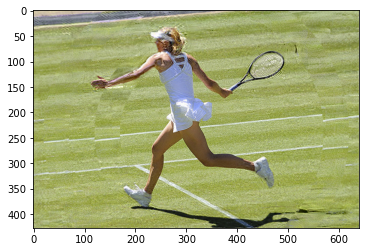

./coco_test/000000000205.jpg


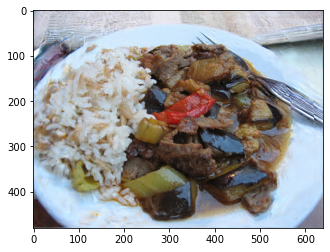

./coco_test/000000000139.jpg


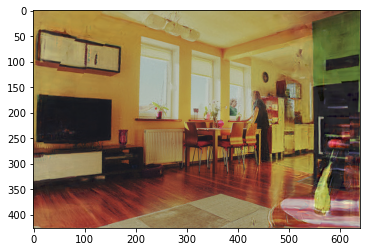

In [28]:
image_num_list =  [19,69,979,552,205,139]
for image_number in image_num_list:
    image_name = str(image_number).zfill(12)
    
    mongs = readin_mongrels(eccentricities, image_name, base_directory)
    psuedo_foveated_mongrel = create_psuedo_foveated_img(mongs)

    plt.imshow(psuedo_foveated_mongrel)
    plt.show()
    psuedo_foveated_mongrel = cv2.cvtColor(psuedo_foveated_mongrel, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'pseudo_foveated_{image_name}.png',psuedo_foveated_mongrel)

In [140]:
r.shape

(500, 332)

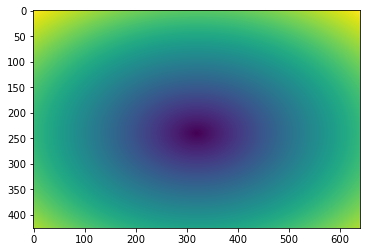

In [55]:
plt.imshow(r.reshape(img_shape[:-1]))